<h1> Simple Moving Average Trading Strategy </h1>

In this notebook we demonstrate a trading strategy where we go long when the short term trend is above the long term trend and short otherwise. We show how to backtest this strategy, and then optimize the size of the rolling average windows used to determine the long/short term trends.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
import pandas_datareader as pdr
from itertools import product

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

We start by loading 8 years of Apple stock data using Pandas data reader. 

In [3]:
ticker = "AAPL"
start = dt.datetime(2010, 1, 4)
end = dt.datetime(2018, 6, 29)

data = pdr.get_data_yahoo(ticker, start, end).dropna()

print(data.head())

                High       Low      Open     Close       Volume  Adj Close
Date                                                                      
2010-01-04  7.660714  7.585000  7.622500  7.643214  493729600.0   6.562591
2010-01-05  7.699643  7.616071  7.664286  7.656429  601904800.0   6.573935
2010-01-06  7.686786  7.526786  7.656429  7.534643  552160000.0   6.469369
2010-01-07  7.571429  7.466071  7.562500  7.520714  477131200.0   6.457407
2010-01-08  7.571429  7.466429  7.510714  7.570714  447610800.0   6.500339


We are going to compare a long term and short term trend, in order to look for times when the short term trend is above or below what should be expected. We estimate these trends using a rolling average of 42 days for the short term trend, and 252 days for the long term trend.

In [4]:
SMA1 = 42
SMA2 = 252

In [5]:
data['SMA1'] = data['Close'].rolling(SMA1).mean()
data['SMA2'] = data['Close'].rolling(SMA2).mean()
data = data[['Close', 'SMA1', 'SMA2']]

<AxesSubplot:xlabel='Date'>

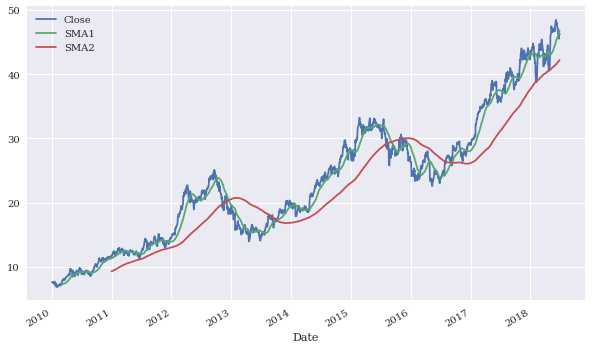

In [6]:
data.plot(figsize=(10, 6))

We now set up a simple trading strategy where we go long when the short SMA is above the longer SMA, and short when this is reversed. The background colour and right axis show when we go long and when we go short. 

In [7]:
data.dropna(inplace=True)
data['position'] = np.where(data.SMA1 > data.SMA2, 1, -1)

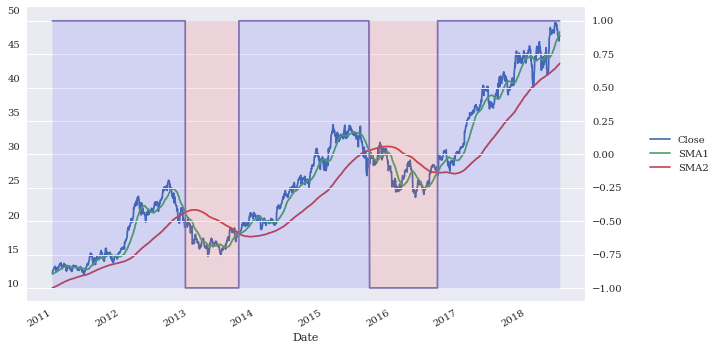

In [8]:
ax = data.plot(secondary_y='position', figsize=(10, 6))
plt.fill_between(data.index, data.position, np.max(data.position), color="red", alpha=0.1)
plt.fill_between(data.index, -data.position, np.max(-data.position), color="blue", alpha=0.1)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

Now we backtest this strategy. To do so we first calculate the log returns over this time period. Then we multiply this by our position (+1 for long, -1 for short) to determine the returns of our strategy. Note that we must shift the time series by one day to avoid foresight bias.

In [9]:
data['returns'] = np.log(data.Close / data.Close.shift(1))

In [10]:
data['strategy_returns'] = data.returns * data.position.shift(1)

In [11]:
data[['cumulative_returns', 'cumulative_strategy_returns']] = \
    data[['returns', 'strategy_returns']].cumsum().apply(np.exp)

Plotting the cumulative returns of our strategy vs a strategy of just going long on the stock shows that our strategy performs better.

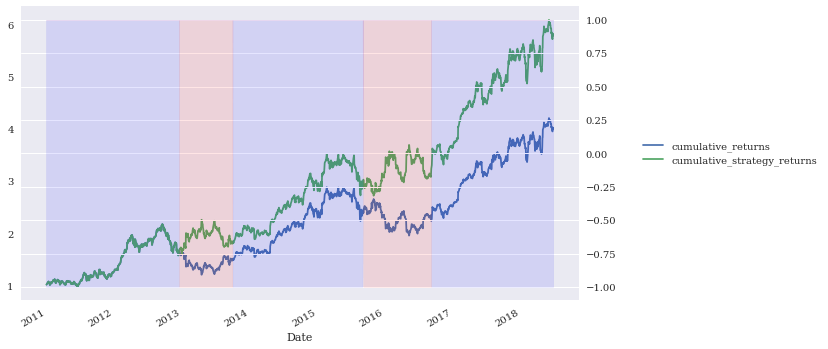

In [12]:
ax = data.plot(y=['cumulative_returns', 'cumulative_strategy_returns'], figsize=(10, 6))
data.plot(y='position', secondary_y='position', figsize=(10, 6), alpha=0.0, ax=ax)
plt.fill_between(data.index, data.position, np.max(data.position), color="red", alpha=0.1)
plt.fill_between(data.index, -data.position, np.max(-data.position), color="blue", alpha=0.1)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

The annualised volatility of each strategy is largely unchanged. 

In [13]:
data[['returns', 'strategy_returns']].std() * 252**0.5

returns             0.250572
strategy_returns    0.250408
dtype: float64

<h3> Optimisation </h3>

Now we repeat the backtesting approach for a range of rolling window lengths to see which maximises profit over this period. Ideally would would not test on the same data we used to build our model, but this is just a practice example so we don't split the data.

In [14]:
sma1 = np.arange(20, 61, 4)
sma2 = np.arange(180, 281, 10)

In [15]:
raw = pdr.get_data_yahoo(ticker, start, end).dropna()

In [16]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1, sma2):
    data = pd.DataFrame(raw['Close']).dropna()
    data['SMA1'] = data.Close.rolling(SMA1).mean()
    data['SMA2'] = data.Close.rolling(SMA2).mean()
    
    data.dropna(inplace=True)
    data['position'] = np.where(data.SMA1 > data.SMA2, 1, -1)
    
    data['returns'] = np.log(data.Close / data.Close.shift(1))
    data['strategy_returns'] = data.returns * data.position.shift(1)
    
    perf = np.exp(data[['returns', 'strategy_returns']].sum())
    
    results = results.append(pd.DataFrame({'SMA1': SMA1,
                                           'SMA2': SMA2,
                                           'market': perf.returns,
                                           'strategy': perf.strategy_returns,
                                           'out': perf.strategy_returns - perf.returns},
                                           index=[0]), ignore_index=True)

The maximum difference between market and strategy is for SMA1=40 and SMA2=190.

In [17]:
results.iloc[results.out.argmax()]

SMA1         40.000000
SMA2        190.000000
market        4.650337
strategy      7.175047
out           2.524710
Name: 56, dtype: float64

Repeat the analysis for the optimal values and plot the cumulative returns.

In [18]:
SMA1, SMA2 = results.iloc[results.out.argmax()][['SMA1', 'SMA2']].astype(int)

data = pd.DataFrame(raw['Close']).dropna()
data['SMA1'] = data.Close.rolling(SMA1).mean()
data['SMA2'] = data.Close.rolling(SMA2).mean()

data.dropna(inplace=True)
data['position'] = np.where(data.SMA1 > data.SMA2, 1, -1)

data['returns'] = np.log(data.Close / data.Close.shift(1))
data['strategy_returns'] = data.returns * data.position.shift(1)

perf = data[['returns', 'strategy_returns']].cumsum().apply(np.exp)
perf.columns = ['cumulative_returns', 'cumulative_strategy_returns']

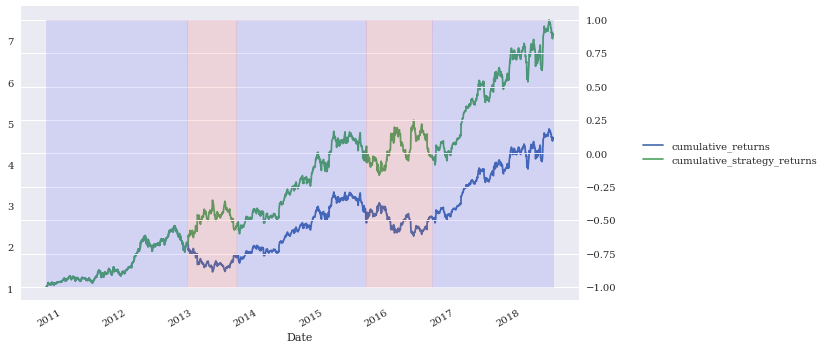

In [19]:
ax = perf.plot(y=['cumulative_returns', 'cumulative_strategy_returns'], figsize=(10, 6))
data.plot(y='position', secondary_y='position', figsize=(10, 6), alpha=0.0, ax=ax)
plt.fill_between(data.index, data.position, np.max(data.position), color="red", alpha=0.1)
plt.fill_between(data.index, -data.position, np.max(-data.position), color="blue", alpha=0.1)
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

We can plot the returns for each value of SMA1 and SMA2 tested to give some idea of if this result is an outlier. The returns for similar window sizes to our winning strategy also have strong returns, suggesting this is not an outlier. 

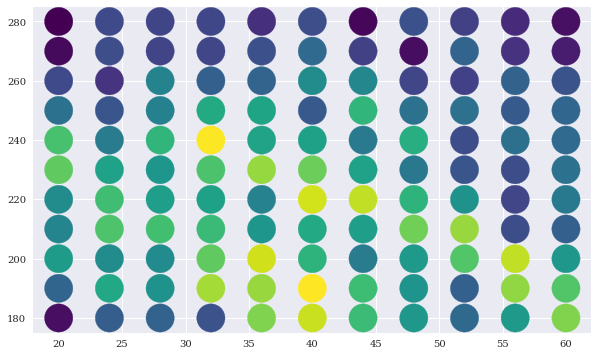

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(results.SMA1, results.SMA2, c=results.out, cmap='viridis', s=800)

In [28]:
alpha1 = np.linspace(0.01, 1, 20)
alpha2 = np.linspace(0.01, 1, 20)

results = pd.DataFrame()
for a1, a2 in product(alpha1, alpha2):
    data = pd.DataFrame(raw['Close']).dropna()
    data['SMA1'] = data.Close.ewm(alpha=a1).mean()
    data['SMA2'] = data.Close.ewm(alpha=a2).mean()
    
    data.dropna(inplace=True)
    data['position'] = np.where(data.SMA1 > data.SMA2, 1, -1)
    
    data['returns'] = np.log(data.Close / data.Close.shift(1))
    data['strategy_returns'] = data.returns * data.position.shift(1)
    
    perf = np.exp(data[['returns', 'strategy_returns']].sum())
    
    results = results.append(pd.DataFrame({'alpha1': a1,
                                           'alpha2': a2,
                                           'market': perf.returns,
                                           'strategy': perf.strategy_returns,
                                           'out': perf.strategy_returns - perf.returns},
                                           index=[0]), ignore_index=True)

In [29]:
results.iloc[results.out.argmax()]

alpha1      1.000000
alpha2      0.843684
market      6.054717
strategy    6.269717
out         0.215000
Name: 396, dtype: float64